In [2]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

BKG = 0
SIGNAL = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

2023-07-07 18:28:24.179419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 18:28:24.372989: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 18:28:25.076855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fabiocfabini/anaconda3/envs/cLip/lib/:/home/fabiocfabini/anaconda3/envs/cLip/lib

device(type='cpu')

In [3]:
bkg_df: pd.DataFrame = pd.read_hdf("data/bkg_pythia_sanitised_features.h5")
fcnc_df: pd.DataFrame = pd.read_hdf("data/fcnc_pythia_sanitised_features.h5")
data: pd.DataFrame = pd.concat([bkg_df, fcnc_df])

## Analysing the data

In [4]:
data.columns

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet1_BTag', 'Jet1_Eta',
       'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'MissingET_MET', 'MissingET_Phi', 'Muon_Multi', 'ScalarHT_HT',
       'gen_decay1', 'gen_decay2', 'gen_decay_filter', 'gen_filter',
       'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter',
       'gen_split', 'gen_weights', 'gen_xsec', 'Jet10_BTag', 'Jet10_Eta',
       'Jet10_Mass', 'Jet10_PT', 'Jet10_Phi', 'Jet6_BTag', 'Jet6_Eta',
   

In [5]:
data.shape

(1093038, 83)

There are more ```Beyond Standard Model, BSM```, events (background) than ```Standard Model, SM```, events (signal)

In [6]:
# BSM events
fcnc_df['gen_sample_filter'].unique()

array(['tZFCNC_PyDelphes'], dtype=object)

In [7]:
# SM events
bkg_df['gen_sample_filter'].unique()

array(['Zjj_HT250to500', 'ttbar_PTtop100to250', 'Zbb_HT500', 'Zjj_HT500',
       'WW_PTW250to500', 'WZ_PTZ250to500', 'ZZ_PTZ0to250', 'WW_PTW500',
       'Zbb_HT250to500', 'WZ_PTZ0to250', 'ZZ_PTZ250to500', 'Zjj_HT0to250',
       'ttbar_PTtop250', 'ZZ_PTZ500', 'WZ_PTZ500', 'Zbb_HT0to250',
       'ttbar_PTtop0to100', 'WW_PTW0to250'], dtype=object)

```gen_label``` column tells us if an event is background or signal.


```gen_xsec``` column tells us the weight associated with each event.

In [8]:
data.rename(columns={
    'gen_label': 'is_signal',
    'gen_xsec': 'weight',
}, inplace=True)

```is_signal``` is either "bkg" or "signal" so let's map to 0, 1.

In [9]:
data['is_signal'] = data['is_signal'].map({'bkg': BKG, 'signal': SIGNAL})

All other columns starting with ```gen``` were created in the Monte Carlo simulation so they can be dropped. Nan values are also dropped.

In [10]:
data = data[[col for col in data.columns if 'gen' not in col]]
data.dropna(axis=1, inplace=True)

The remaining columns represent events that can be ```detected```, if it's ```SM``` or ```BSM```, and the ```weight``` associated with each event.

In [11]:
data.columns

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet1_BTag', 'Jet1_Eta',
       'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'MissingET_MET', 'MissingET_Phi', 'Muon_Multi', 'ScalarHT_HT',
       'is_signal', 'weight'],
      dtype='object')

There is alot more background than signal.

In [12]:
bkg_len, fcnc_len = bkg_df.shape[0], fcnc_df.shape[0]
total = bkg_len + fcnc_len

# Get relative percentage
bkg_percentage = bkg_len / total
fcnc_percentage = fcnc_len / total

bkg_percentage, fcnc_percentage

(0.9171593302337155, 0.08284066976628443)

In [13]:
data.shape

(1093038, 49)

```Why is normalization done only on sampled data?```

In [14]:
# Sample the hole dataset
sample = 100000
fcnc_sample = int(sample * fcnc_percentage)
bkg_sample = int(sample * bkg_percentage)

bkg = data[data['is_signal'] == BKG].sample(bkg_sample, random_state=42)
fcnc = data[data['is_signal'] == SIGNAL].sample(fcnc_sample, random_state=42)

bkg.shape, fcnc.shape

((91715, 49), (8284, 49))

In [15]:
# Splot into train, test and validation dataframes
fcnc_train_df, fcnc_val_df, fcnc_test_df = np.split(fcnc, [int((1 / 3) * len(fcnc)), int((2 / 3) * len(fcnc))])
bkg_train_df, bkg_val_df, bkg_test_df = np.split(bkg, [int((1 / 3) * len(bkg)), int((2 / 3) * len(bkg))])

In [45]:
# Create the train, test and validation datasets
train = pd.concat([fcnc_train_df, bkg_train_df])
val = pd.concat([fcnc_val_df, bkg_val_df])
test = pd.concat([fcnc_test_df, bkg_test_df])

train.shape, val.shape, test.shape

((33332, 49), (33333, 49), (33334, 49))

In [17]:
X_train, y_train, W_train = train.drop(columns=['is_signal', 'weight']), train['is_signal'], train['weight']
X_val, y_val, W_val = val.drop(columns=['is_signal', 'weight']), val['is_signal'], val['weight']
X_test, y_test, W_test = test.drop(columns=['is_signal', 'weight']), test['is_signal'], test['weight']

To normalize the dataset (to deal with the descrepancy between the number of signal and background events), the weights will be modifeid to adjust the importance of each event by dividing them by total sum of the weigths and multiplying by half the number of events in the dataset.

```Why do we multiply by half of the total number of events in the dataset?```

In [18]:
y_train, W_train = y_train.to_numpy(), W_train.to_numpy()
y_val, W_val = y_val.to_numpy(), W_val.to_numpy()
y_test, W_test = y_test.to_numpy(), W_test.to_numpy()

W_train[y_train == SIGNAL] = W_train[y_train == SIGNAL] / W_train[y_train == SIGNAL].sum() * len(W_train) / 2
W_train[y_train == BKG] = W_train[y_train == BKG] / W_train[y_train == BKG].sum() * len(W_train) / 2

W_val[y_val == SIGNAL] = W_val[y_val == SIGNAL] / W_val[y_val == SIGNAL].sum() * len(W_val) / 2
W_val[y_val == BKG] = W_val[y_val == BKG] / W_val[y_val == BKG].sum() * len(W_val) / 2

W_test[y_test == SIGNAL] = W_test[y_test == SIGNAL] / W_test[y_test == SIGNAL].sum() * len(W_test) / 2
W_test[y_test == BKG] = W_test[y_test == BKG] / W_test[y_test == BKG].sum() * len(W_test) / 2

In [19]:
# features = X_train.columns
# num_cols = 5
# num_rows = len(features)//num_cols + 1


# plt.clf()
# fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 60*num_cols//num_rows))

# density = True

# for idx, feature in tqdm(enumerate(features), total=len(features), desc="Plotting features"):

#     h_bkg, b  = np.histogram(X_train[y_train == BKG][feature], bins=100, density=density, weights=W_train[y_train == BKG])
#     h_sgn, _  = np.histogram(X_train[y_train == SIGNAL][feature], bins=b, density=density, weights=W_train[y_train == SIGNAL])

#     bincentres = [(b[i]+b[i+1])/2. for i in range(len(b)-1)]
#     binwidth = b[1]-b[0]


#     ax[idx//num_cols, idx%num_cols].grid(True, linestyle='--', alpha=0.5)
#     ax[idx//num_cols, idx%num_cols].set_title(feature)
#     ax[idx//num_cols, idx%num_cols].bar(bincentres, h_bkg, label="Background", width=binwidth, color ="tab:blue", alpha=0.5)
#     ax[idx//num_cols, idx%num_cols].bar(bincentres, h_sgn, bottom=h_bkg if not density else 0, label="Signal", width=binwidth, color ="tab:orange", alpha=0.5)
#     ax[idx//num_cols, idx%num_cols].set_yscale("log")
#     ax[idx//num_cols, idx%num_cols].legend()

# fig.tight_layout()
# plt.show()

Finally, we zscore the data to have a mean of 0 and a standard deviation of 1.

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.mean(), X_train.std()

(7.329465908349027e-18, 0.9999999999999998)

## Training the model

### With Keras

In [21]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', weighted_metrics=['accuracy', keras.metrics.AUC()])

2023-07-07 18:28:33.761820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [22]:
# On error due to CuDNN version mismatch downgrade tensorflow according to this page: https://www.tensorflow.org/install/source#cpu
# On "Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice" error go to this page: https://www.tensorflow.org/install/pip and scroll down to step (6. Verify install)

history = model.fit(
    x=X_train,
    y=y_train,
    sample_weight=W_train,
    validation_data=(X_val, y_val, W_val),
    epochs=100,
    callbacks = [ keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    batch_size=1024,
    validation_batch_size=2048,
    verbose=1,
)

Epoch 1/100
33/33 [==============================] - 8s 188ms/step - loss: 0.5522 - accuracy: 0.7222 - auc: 0.8013 - val_loss: 0.4776 - val_accuracy: 0.7661 - val_auc: 0.8513
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.4349 - accuracy: 0.8001 - auc: 0.8782 - val_loss: 0.4313 - val_accuracy: 0.7914 - val_auc: 0.8800
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 0.3944 - accuracy: 0.8199 - auc: 0.9014 - val_loss: 0.4042 - val_accuracy: 0.8193 - val_auc: 0.8960
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.3676 - accuracy: 0.8335 - auc: 0.9157 - val_loss: 0.3838 - val_accuracy: 0.8327 - val_auc: 0.9067
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.3456 - accuracy: 0.8475 - auc: 0.9265 - val_loss: 0.3702 - val_accuracy: 0.8370 - val_auc: 0.9129
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.3250 - accuracy: 0.8581 - auc: 0.9356 - val_loss: 0.3591 -

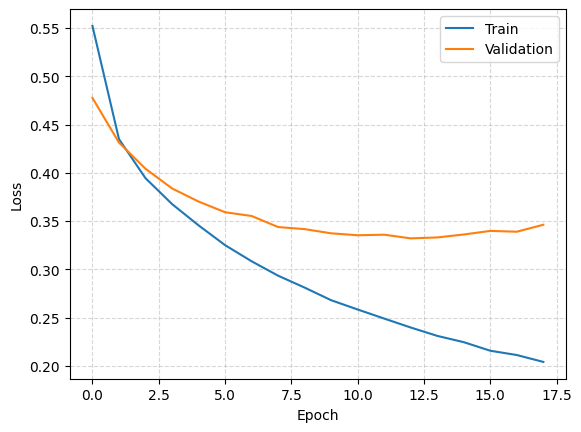

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [24]:
y_preds = model.predict(X_val, batch_size=2048).reshape(-1)

accuracy_score(y_val, y_preds.round(), sample_weight=W_val), roc_auc_score(y_val, y_preds, sample_weight=W_val)

17/17 [==============================] - 0s 3ms/step


(0.8481439270380801, 0.928433635042265)

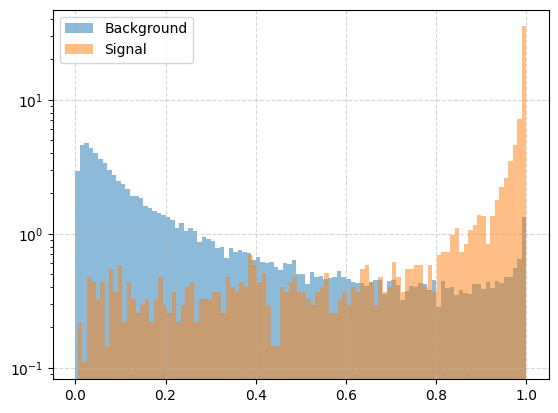

In [25]:
# Histogram of y_preds
plt.hist(y_preds[y_val == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(y_preds[y_val == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

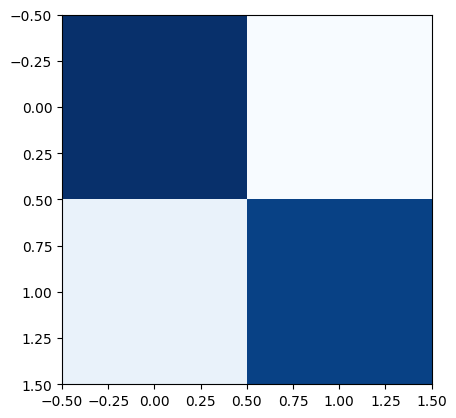

In [26]:
plt.imshow(confusion_matrix(y_val, y_preds.round(), sample_weight=W_val), cmap='Blues')
plt.show()

In [27]:
y_preds = model.predict(X_test, batch_size=2048).reshape(-1)
accuracy_score(y_test, y_preds.round(), sample_weight=W_test), roc_auc_score(y_test, y_preds, sample_weight=W_test)

17/17 [==============================] - 0s 3ms/step


(0.8640235414609017, 0.9311504201296922)

In [28]:
y_preds.shape

(33334,)

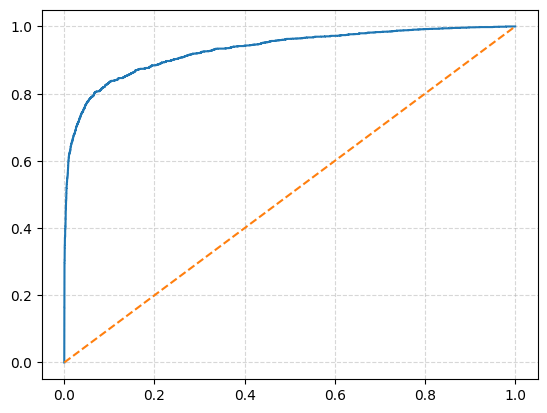

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_preds, sample_weight=W_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### With pytorch

In [30]:
# Import all the necessary libraries for pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### Create Custom Dataset

In [31]:
from typing import Tuple

class CustomDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        self.X = X
        self.y = y
        self.w = w

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        return self.X[idx], self.y[idx], self.w[idx]

train_data = CustomDataset(X_train, y_train.astype('float64'), W_train)
test_data = CustomDataset(X_test, y_test.astype('float64'), W_test)
val_data = CustomDataset(X_val, y_val.astype('float64'), W_val)

train_loader = DataLoader(train_data, batch_size=1024, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=False)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False)

### Creating the Model (Simple Dense Network)

In [32]:
class Network(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Early Stopping

In [33]:
class EarlyStopping:
    def __init__(self, tolerance=5):

        self.tolerance = tolerance
        self.min_validation = np.Inf
        self.counter = 0
        self.early_stop = False
        self.was_triggered = False

    def __call__(self, validation_loss):
        if self.was_triggered:
            self.early_stop = False
            return

        if validation_loss > self.min_validation:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                self.was_triggered = True
        else:
            self.min_validation = validation_loss
            self.counter = 0

##### training with weights

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Saving model at epoch 111
Accuracy: 0.7886542269154617


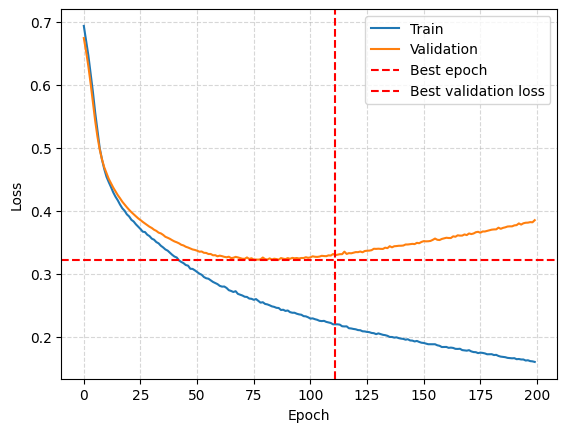

In [35]:
model = Network(X_train.shape[1]).to(DEVICE)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
callback = EarlyStopping(tolerance=25)

# Train the model
train_losses = []
val_losses = []
best_val_loss = np.Inf
best_epoch = 0
for epoch in tqdm(range(200), desc="Training"):
    model.train()
    train_epoch_loss = 0
    for batch, (X, y, w) in enumerate(train_loader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        w = w.to(DEVICE)

        y_preds = model(X).squeeze()

        loss_fn.weight = w
        loss = loss_fn(y_preds, y)
        train_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_epoch_loss / len(train_loader)

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch, (X, y, w) in enumerate(val_loader):
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            w = w.to(DEVICE)

            y_preds = model(X).squeeze()

            loss_fn.weight = w
            loss = loss_fn(y_preds, y)
            val_epoch_loss += loss.item()

    val_loss = val_epoch_loss / len(val_loader)

    callback(val_loss)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'model.pth')
        best_val_loss = callback.min_validation
        best_epoch = epoch


    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Test the model
model.load_state_dict(torch.load('model.pth'))
model.eval()

correct = 0
y_preds_list = []
with torch.no_grad():
    for batch, (X, y, w) in enumerate(test_loader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        w = w.to(DEVICE)

        y_preds = model(X).squeeze()
        y_preds_list.append(y_preds)

y_preds = torch.cat(y_preds_list).cpu().numpy()

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.axvline(best_epoch, color='red', linestyle='--', label='Best epoch')
plt.axhline(best_val_loss, color='red', linestyle='--', label='Best validation loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

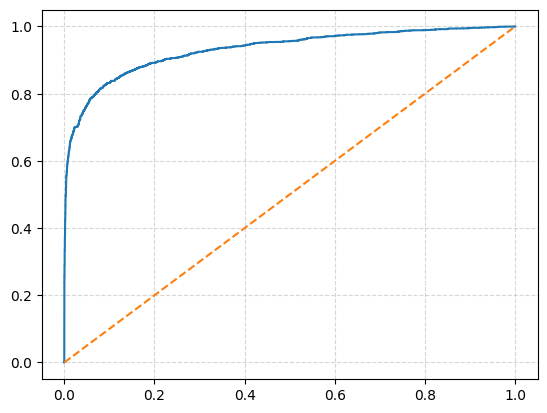

(0.8677398589793354, 0.9316690459349318)

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_preds, sample_weight=W_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
accuracy_score(y_test, y_preds.round(), sample_weight=W_test), roc_auc_score(y_test, y_preds, sample_weight=W_test)

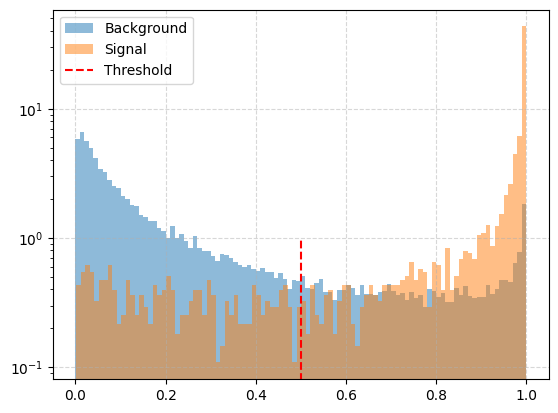

In [49]:
# Histogram of y_preds
plt.hist(y_preds[y_test == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(y_preds[y_test == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.vlines(0.5, 0, 1, color='red', linestyle='--', label='Threshold')
plt.yscale("log")
plt.legend()
plt.show()

#### With AE

In [34]:
from typing import List

class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, arch: List[int]):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.arch = arch

        if len(arch) == 0:
            raise ValueError("Encoder architecture must have at least one layer")

        if latent_dim >= arch[-1]:
            raise ValueError("Latent dimension must be smaller than the last encoder layer")

        self.encoder = self._encoder()
        self.decoder = self._decoder()

    def _encoder(self) -> nn.Sequential:
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.arch[0]),
            nn.ReLU()
        )

        for i in range(1, len(self.arch)):
            self.encoder.add_module(f"fc({i})", nn.Linear(self.arch[i - 1], self.arch[i]))
            self.encoder.add_module(f"A({i})", nn.ReLU())

        self.encoder.add_module("encoder_output", nn.Linear(self.arch[-1], self.latent_dim))

        return self.encoder

    def _decoder(self) -> nn.Sequential:
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.arch[-1]),
            nn.ReLU()
        )

        for i in range(len(self.arch) - 1, 0, -1):
            self.decoder.add_module(f"fc({i})", nn.Linear(self.arch[i], self.arch[i - 1]))
            self.decoder.add_module(f"A({i})", nn.ReLU())

        self.decoder.add_module("decoder_output", nn.Linear(self.arch[0], self.input_dim))

        return self.decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

##### Preparing the dataset

The training of the AE is done only on the background events.
The validation of the AE is also done only on the background events.
To prevent overfitting, the AE is trained on a subset of the background events and validated on another subset of the background events.

The test set is composed of both background and signal events. Hopefully, the AE will be able to reconstruct the background events and not the signal events.

In [50]:
X_train, y_train, W_train = train.drop(columns=['is_signal', 'weight']), train['is_signal'], train['weight']
X_val, y_val, W_val = val.drop(columns=['is_signal', 'weight']), val['is_signal'], val['weight']
X_test, y_test, W_test = test.drop(columns=['is_signal', 'weight']), test['is_signal'], test['weight']

y_train, W_train = y_train.to_numpy(), W_train.to_numpy()
y_val, W_val = y_val.to_numpy(), W_val.to_numpy()
y_test, W_test = y_test.to_numpy(), W_test.to_numpy()

W_train[y_train == SIGNAL] = W_train[y_train == SIGNAL] / W_train[y_train == SIGNAL].sum() * len(W_train) / 2
W_train[y_train == BKG] = W_train[y_train == BKG] / W_train[y_train == BKG].sum() * len(W_train) / 2

W_val[y_val == SIGNAL] = W_val[y_val == SIGNAL] / W_val[y_val == SIGNAL].sum() * len(W_val) / 2
W_val[y_val == BKG] = W_val[y_val == BKG] / W_val[y_val == BKG].sum() * len(W_val) / 2

W_test[y_test == SIGNAL] = W_test[y_test == SIGNAL] / W_test[y_test == SIGNAL].sum() * len(W_test) / 2
W_test[y_test == BKG] = W_test[y_test == BKG] / W_test[y_test == BKG].sum() * len(W_test) / 2

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

ae_train_loader = DataLoader(CustomDataset(X_train[y_train == BKG], X_train[y_train == BKG], W_train[y_train == BKG]), batch_size=1024, shuffle=True, num_workers=8)
ae_val_loader = DataLoader(CustomDataset(X_val[y_val == BKG], X_val[y_val == BKG], W_val[y_val == BKG]), batch_size=1024, shuffle=False)
ae_test_loader = DataLoader(CustomDataset(X_test, X_test, W_test), batch_size=1024, shuffle=False)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

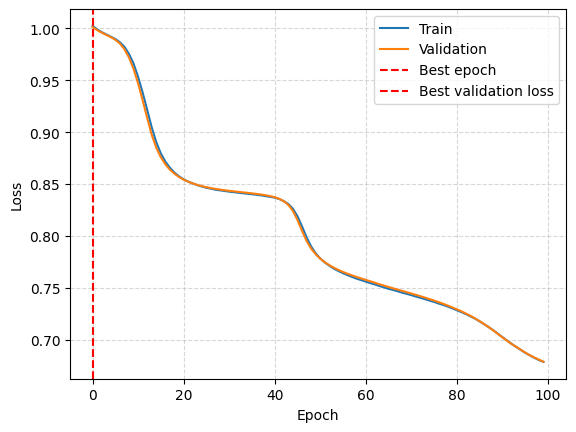

In [51]:
model = AutoEncoder(X_train.shape[1], 6, [32, 16, 8]).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
callback = EarlyStopping(tolerance=25)

# Train the model
train_losses = []
val_losses = []
best_val_loss = np.Inf
best_epoch = 0
for epoch in tqdm(range(100), desc="Training"):
    model.train()
    train_epoch_loss = 0
    for batch, (X, _, w) in enumerate(ae_train_loader):
        X = X.to(DEVICE)
        w = w.to(DEVICE)

        X_preds = model(X)

        loss_fn.weight = w
        loss = loss_fn(X_preds, X)
        train_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_epoch_loss / len(ae_train_loader)

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch, (X, _, w) in enumerate(ae_val_loader):
            X = X.to(DEVICE)
            w = w.to(DEVICE)

            X_preds = model(X)

            loss_fn.weight = w
            loss = loss_fn(X_preds, X)
            val_epoch_loss += loss.item()

    val_loss = val_epoch_loss / len(ae_val_loader)

    callback(val_loss)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
        best_val_loss = callback.min_validation
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.axvline(best_epoch, color='red', linestyle='--', label='Best epoch')
plt.axhline(best_val_loss, color='red', linestyle='--', label='Best validation loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()